# OpenAI Whisper

Transcribe and translate a video.

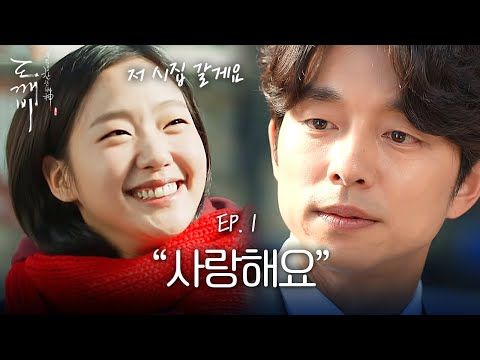

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('UucULf34v4g', width=800, height=450)

## Whisper 설치

In [2]:
!pip install -qq git+https://github.com/openai/whisper.git
!sudo apt update && sudo apt install ffmpeg

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.2 MB/s eta 0:00:00
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [830 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,077 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-ba

## Whisper 사용

### Models

- tiny.en
- tiny
- base.en
- base
- small.en
- small
- medium.en
- medium
- large-v1
- large-v2
- large

## 유튜브 영상 다운로드

In [3]:
!pip install -qq pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.8 MB/s eta 0:00:00


https://youtu.be/hfDagUCZvU4

In [5]:
from pytube import YouTube

yt = YouTube('https://youtu.be/UucULf34v4g')

yt.streams.filter(file_extension='mp4').get_by_resolution('720p').download(
    output_path='.', filename='input.mp4')

'/content/./input.mp4'

## 영상 트림(Trim) 및 오디오 파일 추출

In [6]:
!ffmpeg -y -i input.mp4 -ss 00:01:22 -to 00:01:39 -hide_banner -loglevel error cut.mp4

In [7]:
!ffmpeg -y -i cut.mp4 -q:a 0 -map a -hide_banner -loglevel error audio.mp3

In [8]:
from IPython.display import Audio

Audio('audio.mp3')

## Transcribe

In [9]:
import whisper
model = whisper.load_model('medium')

result = model.transcribe('audio.mp3')

result['text']

100%|██████████████████████████████████████| 1.42G/1.42G [00:15<00:00, 101MiB/s]


' 뭘? 마음 먹었어요 제가. 뭘? 저 시집 갈게요 아저씨한테. 난 아무 만 생각해도 아저씨가 도깨비 맞는 것 같거든요. 사랑해요.'

## 번역

In [10]:
result = model.transcribe('audio.mp3', task='translate')

result['text']

" What? I've made up my mind. What? I'm going to marry you. I think you're a goblin no matter what you think. I love you."

## 구간별 결과

In [11]:
for r in result['segments']:
    print(f'[{r["start"]} --> {r["end"]}] {r["text"]}')

[0.0 --> 1.0]  What?
[1.0 --> 2.0]  I've made up my mind.
[2.0 --> 3.0]  What?
[3.0 --> 5.0]  I'm going to marry you.
[5.0 --> 9.0]  I think you're a goblin no matter what you think.
[9.0 --> 10.0]  I love you.


## 얼굴 탐지 (MediaPipe)

In [12]:
!pip install -qq mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 14.8 MB/s eta 0:00:00


In [13]:
import cv2
import mediapipe as mp

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

face_detection = mp_face_detection.FaceDetection(
    model_selection=0,
    min_detection_confidence=0.8)

## 결과!!!

In [14]:
import math

cap = cv2.VideoCapture('cut.mp4')

w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc('D','I','V','X')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (w, h))

frame_num = 0

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    cur_sec = frame_num / fps

    result_img = img.copy()

    img.flags.writeable = False
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_detection.process(img)

    if results.detections:
        for detection in results.detections:
            text = ''
            for r in result['segments']:
                if r['start'] < cur_sec <= r['end']:
                    text = r['text']

            x1 = int(detection.location_data.relative_bounding_box.xmin * w)
            y1 = int(detection.location_data.relative_bounding_box.ymin * h) - 50

            for i in range(math.ceil(len(text)/40)):
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 1
                font_thickness = 2
                font_coords = (x1, y1+(i*25))
                t = text[i*40:(i+1)*40].strip()

                cv2.putText(result_img, text=t, org=font_coords, fontFace=font, fontScale=font_scale, color=(0, 0, 0), thickness=font_thickness*5)
                cv2.putText(result_img, text=t, org=font_coords, fontFace=font, fontScale=font_scale, color=(255, 255, 255), thickness=font_thickness)

    out.write(result_img)

    frame_num += 1

cap.release()
out.release()

In [15]:
# 영상+음성 합치기
!ffmpeg -i output.mp4 -i audio.mp3 -c:v copy -c:a aac -strict experimental result.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab